In [ ]:
#https://t.me/ai_WorkAssistant_bot

In [1]:
import pandas as pd
import numpy as np
import difflib
from annoy import AnnoyIndex
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from natasha import Segmenter, MorphVocab, Doc, NewsMorphTagger, NewsEmbedding, NewsSyntaxParser
import string
import re

In [3]:
import torch
from transformers import AutoTokenizer, AutoModel

/home/tanya/anaconda3/lib/python3.9/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [38]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import GenerationConfig

In [44]:
use_cuda = torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")
device = "cpu"
generation_config = GenerationConfig.from_pretrained("Den4ikAI/FRED-T5-LARGE_text_qa")
tokenizer = AutoTokenizer.from_pretrained("Den4ikAI/FRED-T5-LARGE_text_qa")
model = AutoModelForSeq2SeqLM.from_pretrained("Den4ikAI/FRED-T5-LARGE_text_qa").to(device)
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(50364, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50364, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [6]:
#import natasha
#natasha.__version__

In [7]:
# модели для NER
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)

stopwords_nltk=[]

def lemmatizer(text):
    '''Лемматизатор для natasha'''
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    res = " ".join([_.lemma for _ in doc.tokens if _.lemma not in stopwords_nltk])

    return res

def full_clean(s):
    '''Очистка текста отдельного письма'''
    s = re.sub(r"[^a-zA-Zа-яА-Я0-9#]", " ", s)
    s = s.lower()  # все нижний регистр
    s = re.sub(" +", " ", s)  # оставляем только 1 пробел
    text = lemmatizer(s)

    return text

In [8]:
def tfidf_featuring(tfidf, df):   
    '''Преобразование текста в мешок слов'''
    X_tfidf = tfidf.transform(df)
    #feature_names = tfidf.get_feature_names_out()
    #X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = feature_names, index = df.index)
    
    return X_tfidf.toarray().tolist()


In [9]:
def generate(prompt):
    data = tokenizer(f"{prompt}", return_tensors="pt").to(model.device)
    output_ids = model.generate(
        **data,
        generation_config=generation_config
    )[0]
    print(tokenizer.decode(data["input_ids"][0].tolist()))
    out = tokenizer.decode(output_ids.tolist())
    return out

In [67]:
data = pd.read_csv('faq.csv', index_col=None, sep=",")[["id", 'Вопрос', "Ответ", "Источник"]]
data.head()

,id,Вопрос,Ответ,Источник
0,1,Что такое закупка?,"Компании, которые частично или полностью прина...",NaN
1,2,Какие группы закупок в зависимости от заказчиков?,Закупки делят на три группы в зависимости от з...,NaN
2,3,Где и как искать закупки?,Закупки по 44-ФЗ обязательно публикуются на za...,NaN
3,4,Что такое извещение о закупке?,"Извещение о закупке — документ, объявляющий о ...",NaN
4,5,Состав извещения о закупке,Заказчики по 44-ФЗ и 223-ФЗ всегда указывают в...,NaN


In [68]:
data['clean'] = data['Вопрос'].apply(lambda x: full_clean(x))

In [69]:
#тренировка модели token_pattern=r'(?u)\b\w\w+\b'
tfidf = TfidfVectorizer(max_features=2000, #max_df = 0.9,
                        #analyzer='char_wb', ngram_range=(3, 5), 
                        analyzer='word', ngram_range=(1, 2), 
                        token_pattern=r'(?u)\b[а-яА-ЯёЁa-zA-Z][а-яА-ЯёЁa-zA-Z]+\b',
                        #tokenizer=lemmatize,
                        lowercase = True, sublinear_tf=True)
tfidf.fit(data['clean'])

TfidfVectorizer(max_features=2000, ngram_range=(1, 2), sublinear_tf=True,
                token_pattern='(?u)\\b[а-яА-ЯёЁa-zA-Z][а-яА-ЯёЁa-zA-Z]+\\b')

In [70]:
#```Сохранение результатов TfidfVectorizer для веб-приложения
joblib.dump(tfidf, 'atom-bot/model/tfidf.pkl') 
#Загрузка
#tfidf = joblib.load('tfidf.pkl')``` 


['atom-bot/model/tfidf.pkl']

In [71]:
# Мешок слов по всем текстам, тренирвочным и тестовым вместе
X_tfidf = tfidf_featuring(tfidf, data['clean'])
data['embed']=X_tfidf
data

,id,Вопрос,Ответ,Источник,clean,embed
0,1,Что такое закупка?,"Компании, которые частично или полностью прина...",NaN,что такой закупка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,Какие группы закупок в зависимости от заказчиков?,Закупки делят на три группы в зависимости от з...,NaN,какой группа закупка в зависимость от заказчик,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,Где и как искать закупки?,Закупки по 44-ФЗ обязательно публикуются на za...,NaN,где и как искать закупка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,Что такое извещение о закупке?,"Извещение о закупке — документ, объявляющий о ...",NaN,что такой извещение о закупка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,Состав извещения о закупке,Заказчики по 44-ФЗ и 223-ФЗ всегда указывают в...,NaN,состав извещение о закупка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
145,146,Предусмотрена ли Законом №223-ФЗ обязанность з...,Обоснование цены договора стало обязательным д...,223-ФЗ,предусмотреть ли закон 223 фз обязанность зака...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
146,147,В каких случаях заказчик обязан установить тре...,Государственный заказчик может установить обес...,223-ФЗ,в какой случай заказчик обязанный установить т...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
147,148,В каких случаях проводится конкурентная закупк...,"В случаях, когда заказчик до начала закупки не...",223-ФЗ,в какой случай проводиться конкурентный закупк...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
148,149,В течение какого срока со дня заключения догов...,"заказчик возвращает денежные средства, внесенн...",223-ФЗ,в течение какой срок с день заключение договор...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [72]:
len(X_tfidf[0])

923

In [73]:
len(data['embed'][0])

923

In [74]:
data.to_csv("atom-bot/data/train_df.csv", index=None, sep=';')

In [75]:
#data = pd.read_csv('atom-bot/data/train_df.csv', index_col=None, sep=";")[["id", 'Вопрос', "Ответ", "embed"]]
#len(data['embed'][0])

In [76]:
#X_tfidf[0]

In [77]:
#data['embed'][0].split(",")

In [78]:
data.head()

,id,Вопрос,Ответ,Источник,clean,embed
0,1,Что такое закупка?,"Компании, которые частично или полностью прина...",NaN,что такой закупка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,Какие группы закупок в зависимости от заказчиков?,Закупки делят на три группы в зависимости от з...,NaN,какой группа закупка в зависимость от заказчик,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,Где и как искать закупки?,Закупки по 44-ФЗ обязательно публикуются на za...,NaN,где и как искать закупка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,Что такое извещение о закупке?,"Извещение о закупке — документ, объявляющий о ...",NaN,что такой извещение о закупка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,Состав извещения о закупке,Заказчики по 44-ФЗ и 223-ФЗ всегда указывают в...,NaN,состав извещение о закупка,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [79]:
#"angular", "euclidean", "manhattan", "hamming", or "dot" 384 768 1024
f=len(X_tfidf[0])
t = AnnoyIndex(f, metric = 'angular')

# train['id'], 
for user_id, user_embedding in enumerate(data['embed']):
    t.add_item(user_id, user_embedding)
t.build(-1)

True

In [80]:
#сохранение индекса
t.save('atom-bot/model/train.ann')

#t = AnnoyIndex(f, 'angular')
#t.load('train.ann') 

True

In [81]:
def predict_nns(find, df, n=1):
    user_embed = tfidf_featuring(tfidf, [find])[0]
    idx, dist = t.get_nns_by_vector(user_embed, 1, search_k=-1, include_distances=True)  
    if dist[0] < 1.1:
        return df['Ответ'][idx].values[0], df['Источник'][idx].values[0]
    else:
        return "Не могу ответить на вопрос", ' '

In [82]:
find=full_clean("Какие можно дать советы постановщику задач?")
predict_nns(find, data)

('Не могу ответить на вопрос', ' ')

In [83]:
find=full_clean("Что понимается под продукцией по ЕОСЗ?")
predict_nns(find, data)

('услуги банков и небанковских кредитных организаций, услуги на рынке ценных бумаг, а также услуги, связанные с предоставлением гарантий (поручительств), с привлечением и/или размещением денежных средств юридических и физических лиц (за исключением услуг страхования и лизинга), оказываемые в соответствии с законодательством;',
 'ЕОСЗ Термины и определения')

In [84]:
find=full_clean("Какие законы регулируют закупочную деятельность?")
predict_nns(find, data)

('Закупки за счёт средств федерального бюджета:\n- № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд»\nЗакупки за счёт собственных средств:\n- № 223-ФЗ «О закупках товаров, работ, услуг отдельными видами юридических лиц»\n- ЕОСЗ «Единый отраслевой стандарт закупок (Положение о Закупке) Госкорпорации «Росатом»»\nЗакупочную деятельность атомной отрасли регулируют так же и другие нормативно-правовые акты РФ, в том числе Конституция, Гражданский и Административный кодекс, Закон о конкуренции и прочие',
 'ЕОСЗ')

Семантический поиск

In [85]:
data1 = pd.read_csv('BD.csv', index_col=None, sep=",")[["id", 'title', "text", "source"]]
data1.head()

,id,title,text,source
0,1,ПОЛИТИКА АТОМНОЙ ОТРАСЛИ В ОБЛАСТИ ЗАКУПОК,Статья 1.1. Цели настоящего Стандарта \nСтанда...,ЕОСЗ Глава 1
1,2,СФЕРА ПРИМЕНЕНИЯ СТАНДАРТА,Статья 2.1. Область применения Стандарта\nСтан...,ЕОСЗ Глава 2
2,3,ГЛАВА 3. ФУНКЦИИ И ПОЛНОМОЧИЯ,"Статья 3.1. Функции и полномочия Корпорации, е...",ЕОСЗ Глава 3
3,4,ГЛАВА 3. ФУНКЦИИ И ПОЛНОМОЧИЯ,Статья 3.3. Функции и полномочия отдельных суб...,ЕОСЗ Глава 3
4,5,ГЛАВА 4. ПЛАНИРОВАНИЕ ЗАКУПОК,Статья 4.1. Формирование и корректировка ГПЗ. ...,ЕОСЗ Глава 4


In [86]:
data1['clean'] = data1['text'].apply(lambda x: full_clean(x))

In [87]:
#тренировка модели token_pattern=r'(?u)\b\w\w+\b'
tfidf = TfidfVectorizer(max_features=2000, #max_df = 0.9,
                        #analyzer='char_wb', ngram_range=(3, 5), 
                        analyzer='word', ngram_range=(1, 2), 
                        token_pattern=r'(?u)\b[а-яА-ЯёЁa-zA-Z][а-яА-ЯёЁa-zA-Z]+\b',
                        #tokenizer=lemmatize,
                        lowercase = True, sublinear_tf=True)
tfidf.fit(data1['clean'])

TfidfVectorizer(max_features=2000, ngram_range=(1, 2), sublinear_tf=True,
                token_pattern='(?u)\\b[а-яА-ЯёЁa-zA-Z][а-яА-ЯёЁa-zA-Z]+\\b')

In [88]:
#```Сохранение результатов TfidfVectorizer для веб-приложения
joblib.dump(tfidf, 'atom-bot/model/tfidf1.pkl') 
#Загрузка
#tfidf = joblib.load('tfidf.pkl')``` 


['atom-bot/model/tfidf1.pkl']

In [97]:
# Мешок слов по всем текстам, тренирвочным и тестовым вместе
X_tfidf1 = tfidf_featuring(tfidf, data1['clean'])
data1['embed']=X_tfidf1
data1.head()

,id,title,text,source,clean,embed
0,1,ПОЛИТИКА АТОМНОЙ ОТРАСЛИ В ОБЛАСТИ ЗАКУПОК,Статья 1.1. Цели настоящего Стандарта \nСтанда...,ЕОСЗ Глава 1,статья 1 1 цель настоящий стандарт стандарт ра...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,СФЕРА ПРИМЕНЕНИЯ СТАНДАРТА,Статья 2.1. Область применения Стандарта\nСтан...,ЕОСЗ Глава 2,статья 2 1 область применение стандарт стандар...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.040..."
2,3,ГЛАВА 3. ФУНКЦИИ И ПОЛНОМОЧИЯ,"Статья 3.1. Функции и полномочия Корпорации, е...",ЕОСЗ Глава 3,статья 3 1 функция и полномочие корпорация ее ...,"[0.0, 0.0, 0.07022684166223907, 0.0, 0.0, 0.0,..."
3,4,ГЛАВА 3. ФУНКЦИИ И ПОЛНОМОЧИЯ,Статья 3.3. Функции и полномочия отдельных суб...,ЕОСЗ Глава 3,статья 3 3 функция и полномочие отдельный субъ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0524200278793..."
4,5,ГЛАВА 4. ПЛАНИРОВАНИЕ ЗАКУПОК,Статья 4.1. Формирование и корректировка ГПЗ. ...,ЕОСЗ Глава 4,статья 4 1 формирование и корректировка гпз ра...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [90]:
#"angular", "euclidean", "manhattan", "hamming", or "dot" 384 768 1024
f=len(X_tfidf1[0])
t1 = AnnoyIndex(f, metric = 'angular')

# train['id'], 
for user_id, user_embedding in enumerate(X_tfidf1):
    t1.add_item(user_id, user_embedding)
t1.build(-1)

True

In [91]:
f

2000

In [92]:
def predict_nns_1(find, df, n=1):
    user_embed = tfidf_featuring(tfidf, [find])[0]
    idx, dist = t1.get_nns_by_vector(user_embed, 1, search_k=-1, include_distances=True)  
    if dist[0] < 1.5:
        return df['text'][idx[0]]
    else:
        return "Не могу ответить на вопрос", ' '

In [93]:
find="Что должен содержать запрос ТКП?"

In [94]:
#find="В каких случаях конкурентная закупка признается несостоявшейся?"
sentence = predict_nns_1(find, data1)

In [95]:
sentence

'Статья 6.3. Особенности проведения конкурентных закупок в закрытой форме\nПри проведении конкурентной закупки в закрытой форме применяются общие положения Стандарта о порядке проведения открытых конкурентных закупок (ст. 6.2), положения о порядке проведения соответствующей конкурентной закупки (приложение № 12) с учетом требований настоящей статьи.\nК участию в закрытой конкурентной закупке допускаются только поставщики, приглашенные организатором закупки. В обязательном порядке приглашения направляются организациям атомной отрасли и организациям, являющимся изготовителями закупаемой продукции. Перечень таких поставщиков определяется заказчиком совместно с организатором закупки. При этом приглашение к участию в закрытой закупке не направляется поставщику, сведения о котором содержатся в РНП (глава 10).\nОдновременно с размещением извещения о закупке на официальных сайтах (если подлежит размещению в соответствии со ст. 6.2.1) организатор закупки обязан направить всем поставщикам, пригл

In [ ]:
prompt = '''<SC6>Текст: {}\nВопрос: {}\nОтвет: <extra_id_0>'''.format(sentence, find)
answ = generate(prompt).rsplit('<extra_id_0>')[-1].split("</s>")[0]

In [ ]:
answ

Эмбединги LaBSE для глав нормативных документов

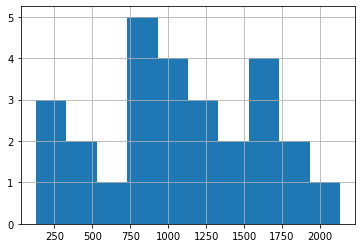

In [10]:
#построим график количества слов, появляющихся в каждом тексте.
def plot_word_number_histogram(text):
    text.str.split().map(lambda x: len(x)).hist(bins=10)
    
plot_word_number_histogram(data1['text'])

In [6]:
sentences = data1['text'].tolist()

In [12]:
# transformers
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
embeddings = model_output.pooler_output
embeddings = torch.nn.functional.normalize(embeddings)
#print(embeddings)

In [13]:
print(embeddings.shape[1])

768


In [15]:
#"angular", "euclidean", "manhattan", "hamming", or "dot" 384 768 1024
f=embeddings.shape[1]
t1 = AnnoyIndex(f, metric = 'angular')

# train['id'], 
for user_id, user_embedding in enumerate(embeddings):
    t1.add_item(user_id, user_embedding)
t1.build(-1)

True

In [31]:
def predict_nns_1(find, sentence, n=1):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    user_embed=embeddings[0].numpy()

    idx, dist = t1.get_nns_by_vector(user_embed, 1, search_k=-1, include_distances=True)  
    if dist[0] < 1.1:
        return sentences[idx[0]]
    else:
        return "Не могу ответить на вопрос", 

In [ ]:
sentence="В каких случаях конкурентная закупка признается несостоявшейся?"
predict_nns_1(find, sentence)

Формулирование ответа внутри главы документа

In [42]:
prompt = '''<SC6>Текст: {}\nВопрос: {}\nОтвет: <extra_id_0>'''.format(sentences[0], sentence)
answ = generate(prompt).rsplit('<extra_id_0>')[-1].split("</s>")[0]

<SC6>Текст: Статья 1.1. Цели настоящего Стандарта 
Стандарт разработан в соответствии с требованиями Федерального закона 
от 18 июля 2011 года № 223-ФЗ «О закупках товаров, работ, услуг отдельными видами юридических лиц» в целях:
обеспечения единства экономического пространства, расширения возможностей участия юридических и физических лиц в закупках продукции для нужд заказчиков и стимулирования такого участия, развития добросовестной конкуренции;
создания условий для своевременного и полного удовлетворения потребностей Корпорации и организаций атомной отрасли в продукции с необходимыми показателями цены, качества и надежности;
эффективного использования денежных средств;
обеспечения гласности и прозрачности закупки;
предотвращения коррупции и других злоупотреблений;
соблюдения законодательства.

Статья 1.2. Принципы закупочной деятельности
Открытость: информационная прозрачность закупок.
Конкурентность: равноправие, справедливость, отсутствие дискриминации и необоснованных ограничений

In [43]:
answ

'\nЗапрос ТКП должен содержать следующие сведения:\n\n1. Цели и задачи Стандарта.\n\n2. Принципы закупочной деятельности.'